In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset 
from torchvision import datasets, transforms as T
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import PIL

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# transformers
def permute(input, permutation):
    return torch.tensor([input[i] for i in permutation])

class MyRandomRotation(object):
    def __init__(self):
        self.permutations = [
            [0, 1, 2, 3, 4, 5],
            [0, 1, 5, 4, 2, 3],
            [0, 1, 3, 2, 5, 4],
            [0, 1, 4, 5, 3, 2],
        ]

    def __call__(self, sample):
        image, label = sample
        rot = random.randint(0, 3)
        image = TF.rotate(image, rot * 90)
        # label: [squares, circles, up, down, left, right]
        label = permute(label, self.permutations[rot])
        return (image, label)


class MyRandomFlip(object):
    def __init__(self):
        self.permutations = [
            [0, 1, 2, 3, 4, 5],
            [0, 1, 2, 3, 5, 4],
        ]

    def __call__(self, sample):
        image, label = sample
        flip = random.randint(0, 1)

        if flip == 1:
            image = TF.hflip(image)
        # label: [squares, circles, up, down, left, right]
        label = permute(label, self.permutations[flip])
        return (image, label)


In [13]:
loader = T.Compose([
    T.ToTensor()])
transform = T.Compose([
    MyRandomRotation(),
    MyRandomFlip()
])


class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, 'name']

        squares = 1 if self.df.loc[index, "squares"] > 0 else 0
        circles = 1 if self.df.loc[index, "circles"] > 0 else 0
        up = 1 if self.df.loc[index, "up"] > 0 else 0
        down = 1 if self.df.loc[index, "down"] > 0 else 0
        right = 1 if self.df.loc[index, "right"] > 0 else 0
        left = 1 if self.df.loc[index, "left"] > 0 else 0

        label = torch.tensor([squares, circles, up, down, left, right])
        image = PIL.Image.open(os.path.join(self.images_folder, filename))


        if self.transform is not None:
            image, label = self.transform((image, label))

        image = loader(image)[0].unsqueeze(0)

        return image.to(device, torch.float), label


In [14]:
image_size = 28
images_folder = './data'
csv_path = './data/labels.csv'

dataset_size = 10000
dev_dataset_size = 1000
val_dataset_size = 1000
train_dataset_size = dataset_size - dev_dataset_size - val_dataset_size

dataset = ClassificationDataset(csv_path, images_folder, transform)
train_dataset = Subset(dataset, range(train_dataset_size))
dev_dataset = Subset(dataset, range(train_dataset_size, train_dataset_size + dev_dataset_size))
val_dataset = Subset(dataset, range(train_dataset_size + dev_dataset_size, dataset_size))

tensor([1, 0, 1, 0, 0, 0])


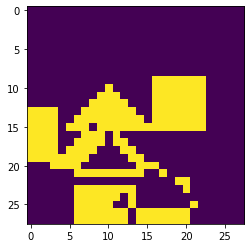

In [15]:
i = 1
d = val_dataset[i]
print(d[1])
plt.imshow(d[0].cpu().numpy().reshape((28, 28)))
# label: [squares, circles, up, down, left, right]


In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.SiLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            )

        self.drop_out_con = nn.Dropout(0.1)
        self.drop_out_fc = nn.Dropout(0.5)

        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU())
       
        self.fc2 = nn.Sequential(
            nn.Linear(64, 6),
            nn.Sigmoid())
    def forward(self, x):
        x = self.layer1(x)
        x = self.drop_out_con(x)
        x = self.layer2(x)
        x = self.drop_out_con(x)
        x = self.layer3(x)

        x = x.view(x.size(0), -1)

        x = self.drop_out_fc(x)
        x = self.fc1(x)
        x = self.drop_out_fc(x)
        x = self.fc2(x)
        return x

In [18]:
batch_size = 100

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

train_generator = DataLoader(train_dataset, **params)
dev_generator = DataLoader(dev_dataset, **params)
val_generator = DataLoader(val_dataset, **params)

In [19]:
learning_rate = 0.005
weight_decay = 0

model = ConvNet()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, dampening=0, weight_decay=weight_decay, nesterov=True)
criterion = torch.nn.BCELoss()

if torch.cuda.is_available():
    model = model.cuda()

print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (drop_out_con): Dropout(p=0.1, inplace=False)
  (drop_out_fc): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=3200, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=6, bias=True)
    (1): Sigmoid()
  )
)


In [20]:
def correct_num(predicted_labels, target_labels):
    maxPred = (predicted_labels.topk(2).indices).sort().values
    maxTarg = (target_labels.topk(2).indices).sort().values
    return (maxPred == maxTarg).prod(1).sum()

In [89]:
def lbl_to_text(lbl):
    names = ['squares', 'circles', 'up', 'down', 'left', 'right']
    classes = lbl.nonzero()
    return f'{names[classes[0]]}-{names[classes[1]]}'

def lbl_to_num(lbl):
    offs = [0, 5, 9, 12, 14]
    classes = lbl.nonzero()
    return (offs[classes[0]] + classes[1] - classes[0] - 1).item()

def pred_to_lbl(pred):
    top2 = pred.topk(2)[1]
    lbl = [0] * 6
    lbl[top2[0]] = 1
    lbl[top2[1]] = 1
    return lbl


[[0, 1, 0, 0, 1, 0],
 [0, 0, 0, 1, 1, 0],
 [1, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1]]

In [21]:
round_num = 6

def train(max_epochs):

    dev_losses = []
    dev_accs = []
    train_losses = []
    train_accs = []

    for epoch in range(max_epochs):
        # Training
        train_loss = 0
        train_correct = 0
        model.train()
        for local_batch, local_labels in train_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            batch_size = local_batch.size()[0]

            optimizer.zero_grad()

            predicted_labels = model(local_batch)
            train_correct = train_correct + correct_num(predicted_labels, local_labels)
            loss = criterion(predicted_labels.to(torch.float32), local_labels.to(torch.float32))
            
            loss.backward()
            optimizer.step()
            train_loss = train_loss + batch_size * loss 

        train_acc = train_correct / train_dataset_size
        train_loss = train_loss / train_dataset_size
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

        # Validation
        dev_loss = 0
        dev_correct = 0
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in dev_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                batch_size = local_batch.size()[0]

                predicted_labels = model(local_batch).to(torch.float32)
                dev_correct = dev_correct + correct_num(predicted_labels, local_labels) 

                dev_loss = dev_loss + batch_size * criterion(predicted_labels.to(torch.float32), local_labels.to(torch.float32))
        dev_acc = dev_correct / dev_dataset_size
        dev_loss = dev_loss / dev_dataset_size
        dev_losses.append(dev_loss.item())
        dev_accs.append(dev_acc.item())
        print('Epoch : ',epoch+1, '\t',
            'train_loss :', round(train_loss.item(), round_num),
            'train_acc:', round(train_acc.item(), round_num),
            'dev_loss :', round(dev_loss.item(), round_num),
            'dev_acc:', round(dev_acc.item(), round_num))
    return dev_losses, dev_accs, train_losses, train_accs


In [22]:
max_epochs = 150
print('TRAINING STARTED')
dev_losses, dev_accs, train_losses, train_accs = train(max_epochs)

TRAINING STARTED
Epoch :  1 	 train_loss : 0.573426 train_acc: 0.196625 dev_loss : 0.486685 dev_acc: 0.294
Epoch :  2 	 train_loss : 0.397721 train_acc: 0.46975 dev_loss : 0.322014 dev_acc: 0.598
Epoch :  3 	 train_loss : 0.2931 train_acc: 0.66475 dev_loss : 0.30278 dev_acc: 0.616
Epoch :  4 	 train_loss : 0.256109 train_acc: 0.72475 dev_loss : 0.180072 dev_acc: 0.852
Epoch :  5 	 train_loss : 0.230683 train_acc: 0.76775 dev_loss : 0.207756 dev_acc: 0.783
Epoch :  6 	 train_loss : 0.209948 train_acc: 0.799375 dev_loss : 0.147114 dev_acc: 0.873
Epoch :  7 	 train_loss : 0.19868 train_acc: 0.80875 dev_loss : 0.133268 dev_acc: 0.899
Epoch :  8 	 train_loss : 0.178861 train_acc: 0.838875 dev_loss : 0.118853 dev_acc: 0.911
Epoch :  9 	 train_loss : 0.173956 train_acc: 0.839125 dev_loss : 0.117854 dev_acc: 0.901
Epoch :  10 	 train_loss : 0.164258 train_acc: 0.85525 dev_loss : 0.113159 dev_acc: 0.905
Epoch :  11 	 train_loss : 0.159306 train_acc: 0.860125 dev_loss : 0.104687 dev_acc: 0.928
E

In [90]:
# validation
val_correct = 0
val_loss = 0
model.eval()
true_lbls = []
pred_lbls = []
with torch.set_grad_enabled(False):
    for local_batch, local_labels in val_generator:
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        batch_size = local_batch.size()[0]

        predicted_labels = model(local_batch).to(torch.float32)

        pred_lbls = pred_lbls + [lbl_to_num(torch.tensor(pred_to_lbl(l))) for l in predicted_labels]
        true_lbls = true_lbls + [lbl_to_num(l) for l in local_labels]
        
        val_correct = val_correct + correct_num(predicted_labels, local_labels) 

        val_loss = val_loss + batch_size * criterion(predicted_labels.to(torch.float32), local_labels.to(torch.float32))
val_acc = val_correct / val_dataset_size
val_loss = val_loss / val_dataset_size

print('validation loss: ', val_loss.item(), 'validation accuracy: ', val_acc.item())


validation loss:  0.05010588839650154 validation accuracy:  0.9610000252723694


<ipython-input-112-8c9c7b864c2d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_texts, rotation=45, va="bottom", ha="left")
<ipython-input-112-8c9c7b864c2d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(label_texts)


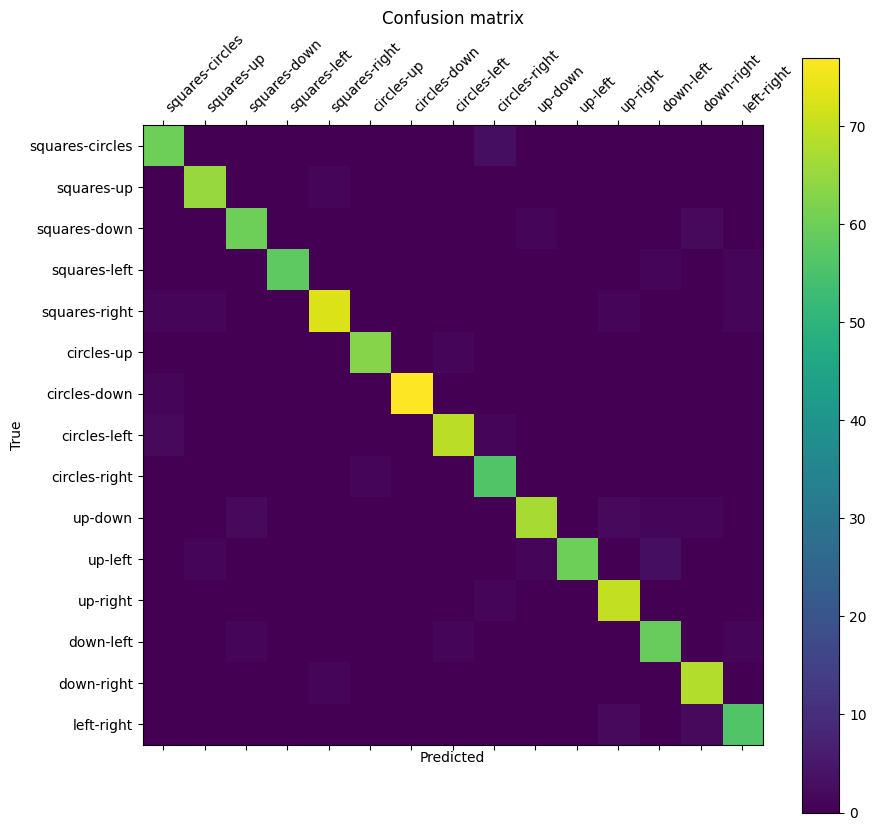

In [112]:
labels = torch.tensor([[1,1,0,0,0,0], [1,0,1,0,0,0], [1,0,0,1,0,0], [1,0,0,0,1,0], [1,0,0,0,0,1], [0,1,1,0,0,0], [0,1,0,1,0,0], [0,1,0,0,1,0], [0,1,0,0,0,1], [0,0,1,1,0,0], [0,0,1,0,1,0], [0,0,1,0,0,1], [0,0,0,1,1,0], [0,0,0,1,0,1], [0,0,0,0,1,1]])
label_texts = [lbl_to_text(l) for l in labels]
cm = confusion_matrix(true_lbls, pred_lbls)

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels(label_texts, rotation=45, va="bottom", ha="left")
ax.set_yticklabels(label_texts)
ax.set_xticks(np.arange(len(label_texts)))
ax.set_yticks(np.arange(len(label_texts)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

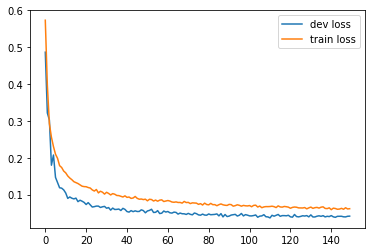

In [24]:
plt.plot(dev_losses)
plt.plot(train_losses)
plt.legend(['dev loss', 'train loss'])
plt.show()

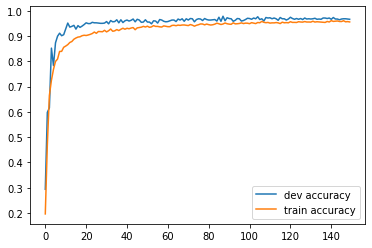

In [25]:
plt.plot(dev_accs)
plt.plot(train_accs)
plt.legend(['dev accuracy', 'train accuracy'])
plt.show()

<ipython-input-26-04c3967bac57>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


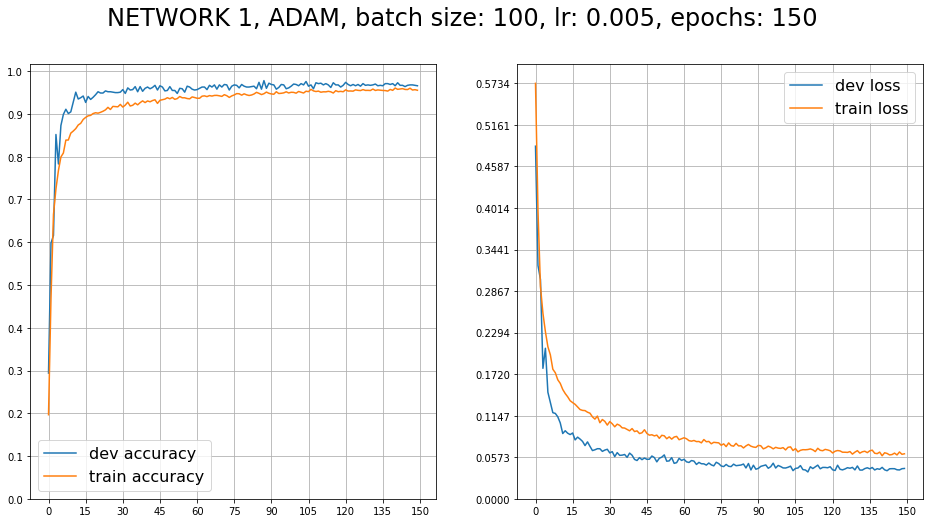

In [26]:
max_loss = max(max(dev_losses), max(train_losses))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'NETWORK 1, ADAM, batch size: {batch_size}, epochs: {max_epochs}', fontsize=24)
ax1.plot(dev_accs)
ax1.plot(train_accs)
ax1.legend(['dev accuracy', 'train accuracy'], fontsize=16)
ax1.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid()

ax2.plot(dev_losses)
ax2.plot(train_losses)
ax2.legend(['dev loss', 'train loss'], fontsize=16)
ax2.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax2.set_yticks(np.arange(0, max_loss + 0.01, max_loss/10))
ax2.grid()

fig.show()